In [1]:
import numpy as np

In [2]:
class LogisticPolicy:
    def __init__(self, θ, α, γ):
        # Initialize paramters θ, learning rate α and discount factor γ

        self.θ = θ
        self.α = α
        self.γ = γ

    def logistic(self, y):
        # definition of logistic function

        return 1 / (1 + np.exp(-y))

    def probs(self, x):
        # returns probabilities of two actions

        y = x @ self.θ
        prob0 = self.logistic(y)

        return np.array([prob0, 1 - prob0])

    def act(self, x):
        # sample an action in proportion to probabilities

        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)

        return action, probs[action]

    def grad_log_p(self, x):
        # calculate grad-log-probs

        y = x @ self.θ
        grad_log_p0 = x - x * self.logistic(y)
        grad_log_p1 = -x * self.logistic(y)

        return grad_log_p0, grad_log_p1

    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # dot grads with future rewards for each action in episode

        return grad_log_p.T @ discounted_rewards

    def discount_rewards(self, rewards):
        # calculate temporally adjusted, discounted rewards

        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
            discounted_rewards[i] = cumulative_rewards

        return discounted_rewards

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grad_log_p = np.array(
            [self.grad_log_p(ob)[action] for ob, action in zip(obs, actions)]
        )

        assert grad_log_p.shape == (len(obs), 4)

        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)

        # gradients times rewards
        dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)

        # gradient ascent on parameters
        self.θ += self.α * dot

In [3]:
def run_episode(env, policy, render=False):

    observation = env.reset()
    totalreward = 0

    observations = []
    actions = []
    rewards = []
    probs = []

    done = False

    while not done:
        if render:
            env.render()

        observations.append(observation)

        action, prob = policy.act(observation)
        observation, reward, done, info = env.step(action)

        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)

    return totalreward, np.array(rewards), np.array(observations), np.array(actions), np.array(probs)

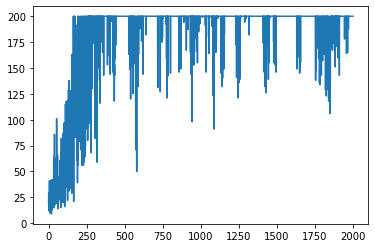

In [4]:
def train(θ, α, γ, Policy, MAX_EPISODES=1000, seed=None, evaluate=False):

    # initialize environment and policy
    env = gym.make('CartPole-v0')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)

    # train until MAX_EPISODES
    import time
    for i in range(MAX_EPISODES):
        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, policy)

        # keep track of episode rewards
        episode_rewards.append(total_reward)

        # update policy
        policy.update(rewards, observations, actions)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False)

    # evaluation call after training is finished - evaluate last trained policy on 100 episodes
    if evaluate:
        env = Monitor(env, 'pg_cartpole/', video_callable=False, force=True)
        for _ in range(100):
            run_episode(env, policy, render=False)
        env.env.close()

    return episode_rewards, policy


# additional imports for saving and loading a trained policy
import gym
import gym.wrappers
from gym.wrappers.monitor import Monitor, load_results

# for reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

episode_rewards, policy = train(θ=np.random.rand(4),
                                α=0.002,
                                γ=0.99,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=2000,
                                seed=GLOBAL_SEED,
                                evaluate=False)

import matplotlib.pyplot as plt
plt.plot(episode_rewards)
plt.show()

In [ ]:
# Reinforce

In [8]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import copy 

#Hyperparameters
NUM_EPISODES = 2000
LEARNING_RATE = 0.002
GAMMA = 0.99

# Create gym and seed numpy
env = gym.make('CartPole-v0')
nA = env.action_space.n
np.random.seed(1)

# Init weight
w = np.random.rand(4, 2)

# Keep stats for final print of graph
episode_rewards = []

# Our policy that maps state to action parameterized by w
def policy(state,w):
	z = state.dot(w)
	exp = np.exp(z)
	return exp/np.sum(exp)

# Vectorized softmax Jacobian
def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

# Main loop 
# Make sure you update your weights AFTER each episode
for e in range(NUM_EPISODES):

	state = env.reset()[None,:]

	grads = []	
	rewards = []

	# Keep track of game score to print
	score = 0

	while True:

		# Uncomment to see your model train in real time (slower)
		#env.render()

		# Sample from policy and take action in environment
		probs = policy(state,w)
		action = np.random.choice(nA,p=probs[0])
		next_state,reward,done,_ = env.step(action)
		next_state = next_state[None,:]

		# Compute gradient and save with reward in memory for our weight updates
		dsoftmax = softmax_grad(probs)[action,:]
		dlog = dsoftmax / probs[0,action]
		grad = state.T.dot(dlog[None,:])

		grads.append(grad)
		rewards.append(reward)		

		score+=reward

		# Dont forget to update your old state to the new state
		state = next_state

		if done:
			break

	# Weight update
	for i in range(len(grads)):

		# Loop through everything that happend in the episode and update towards the log policy gradient times **FUTURE** reward
		w += LEARNING_RATE * grads[i] * sum([ r * (GAMMA ** r) for t,r in enumerate(rewards[i:])])
	
	# Append for logging and print
	episode_rewards.append(score) 
	print("EP: " + str(e) + " Score: " + str(score) + "         ",end="\r", flush=False) 

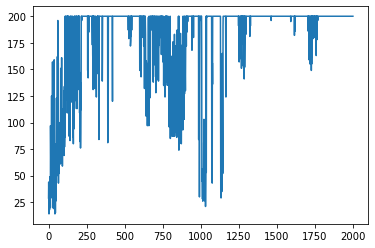

In [9]:
plt.plot(np.arange(NUM_EPISODES),episode_rewards)
plt.show()
env.close()